# 기본설정

In [1]:
# (1) base
import sys,os
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
import numpy as np
import time,datetime
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# (2) plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# (3) stock data
# !pip install finance-datareader
import FinanceDataReader as fdr

# (4) modeling
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.metrics import mean_squared_error

print('> torch version  :',torch.__version__)
print('> cuda available :',torch.cuda.is_available())

> torch version  : 1.14.0.dev20221202
> cuda available : False


In [2]:
from utils.data_loader import StockDataLoader
from models.torch_dataset import TimeSeriesDataset
# from models.torch_model import BiLSTM
from models.torch_build import train

In [3]:
sys.path.append('/Users/khj/Github/hyuckjinkim/lib-python/torch/')
from build_model import EarlyStopping
from torch_seed import seed_everything

<br></br>

In [173]:
# data load
TICKER = 'AAPL'
START_DATE = '2010-01-01'
END_DATE = None

# data preprocess
SCALING = False
TARGET_LOGSCALE = False
LAG_LENGTH = 7

# train test split
SEED = 0
TRAIN_SIZE = 0.8
TRAIN_TEST_METHOD = ['timeseries','random'][0]

# make sequences
SEQUENCE_SIZE = 21 #21
WINDOW_SIZE = 1
FUTURE_SIZE = 1

# data loader
BATCH_SIZE = 32 #32
SHUFFLE = False

# model
BIDIRECTIONAL = False
BATCH_NORM = False
HIDDEN_SIZE = 64 #64
NUM_LAYERS = 2 #2
DROPOUT = 0.5
LEARNING_RATE = 0.001

In [174]:
data_loader = StockDataLoader(
    ticker=TICKER,
    start_date=START_DATE,
    end_date=END_DATE,
    train_size=TRAIN_SIZE,
    train_test_method=TRAIN_TEST_METHOD,
    seed=SEED,
    scaling=SCALING,
    target_logscale=TARGET_LOGSCALE,
    lag_length=LAG_LENGTH,
)
train_data, test_data = data_loader.get_data()

In [175]:
print('TrainSize: {}, TestSize: {}'.format(len(train_data),len(test_data)))

TrainSize: 2671, TestSize: 668


In [176]:
train_data.head()

,date,open,high,low,volume,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,adj_close_lag_4,adj_close_lag_5,adj_close_lag_6,adj_close_lag_7,close_change,volume_change,close_ma_5,close_sd_5,volume_ma_5,volume_sd_5,bollinger_band_upper_5,bollinger_band_lower_5,close_ma_10,close_sd_10,volume_ma_10,volume_sd_10,bollinger_band_upper_10,bollinger_band_lower_10,close_ma_20,close_sd_20,volume_ma_20,volume_sd_20,bollinger_band_upper_20,bollinger_band_lower_20,close_ma_60,close_sd_60,volume_ma_60,volume_sd_60,bollinger_band_upper_60,bollinger_band_lower_60,close_ma_120,close_sd_120,volume_ma_120,volume_sd_120,bollinger_band_upper_120,bollinger_band_lower_120,macd_short,macd_long,macd,macd_signal,macd_sign,mean_close_change_1week,mean_volume_change_1week,mean_close_change_3week,mean_volume_change_3week,mean_close_change_6week,mean_volume_change_6week,mean_close_change_13week,mean_volume_change_13week,mean_close_change_26week,mean_volume_change_26week,mean_close_change_52week,mean_volume_change_52week,adj_close
0,2010-01-04,7.622500,7.660714,7.585000,493729600,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2010,6.405577,6.433239,6.356029,6.432327,6.354208,6.143252,6.090359,1.556503,40.100587,6.426490,0.054059,469599200.0,1.104894e+08,6.534609,6.318372,6.268639,0.199398,476460320.0,1.148788e+08,6.667435,5.869842,6.081439,0.243985,512897280.0,1.432467e+08,6.569409,5.593468,6.032636,0.210985,5.121124e+08,1.971307e+08,6.454606,5.610666,5.597253,0.517851,4.871276e+08,1.733008e+08,6.632955,4.561551,6.203893,6.074390,0.129503,0.001227,1,0.476902,3.187010,0.582433,3.733066,0.141220,5.351744,0.235566,4.326117,0.328492,4.396876,0.356272,3.956538,6.505280
1,2010-01-05,7.664286,7.699643,7.616071,601904800,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2010,6.505280,6.405577,6.433239,6.356029,6.432327,6.354208,6.143252,0.172890,21.909807,6.443330,0.067720,461067040.0,9.402018e+07,6.578771,6.307890,6.326241,0.175889,475773760.0,1.140175e+08,6.678019,5.974463,6.113447,0.257294,501648280.0,1.249581e+08,6.628034,5.598859,6.045357,0.216785,5.148406e+08,1.972233e+08,6.478927,5.611787,5.614352,0.514002,4.880969e+08,1.736171e+08,6.642356,4.586348,6.252908,6.086303,0.166605,0.033720,1,0.265599,1.832118,0.653692,6.009165,0.235187,4.585978,0.275495,4.705599,0.327329,4.746185,0.375142,4.020269,6.516527
2,2010-01-06,7.656429,7.686786,7.526786,552160000,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2010,6.516527,6.505280,6.405577,6.433239,6.356029,6.432327,6.354208,-1.590633,-8.264563,6.454699,0.052450,482457920.0,1.013875e+08,6.559599,6.349799,6.364967,0.141643,469799120.0,1.074687e+08,6.648252,6.081682,6.146914,0.250076,493518340.0,1.152776e+08,6.647065,5.646762,6.055743,0.219244,5.191554e+08,1.951144e+08,6.494230,5.617255,5.630424,0.508490,4.894185e+08,1.734950e+08,6.647404,4.613444,6.301316,6.098439,0.202877,0.067731,1,0.184705,6.365077,0.468543,4.434160,0.191975,5.144308,0.216658,4.494606,0.312933,4.718122,0.366153,4.083964,6.412873
3,2010-01-07,7.562500,7.571429,7.466071,477131200,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2010,6.412873,6.516527,6.505280,6.405577,6.433239,6.356029,6.432327,-0.184863,-13.588235,6.448255,0.057484,495467280.0,9.400452e+07,6.563223,6.333287,6.396033,0.103710,482560680.0,9.882799e+07,6.603454,6.188612,6.178390,0.239740,482854960.0,1.055617e+08,6.657871,5.698909,6.065759,0.221085,5.223072e+08,1.928316e+08,6.507928,5.623589,5.645326,0.504604,4.883766e+08,1.731875e+08,6.654535,4.636118,6.339692,6.110913,0.228779,0.100330,1,-0.095217,5.135336,0.551320,4.554663,0.086439,4.132101,0.204495,4.647505,0.326645,4.694758,0.371408,4.251980,6.401018
4,2010-01-08,7.510714,7.571429,7.466429,447610800,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,2010,6.401018,6.412873,6.516527,6.505280,6.405577,6.433239,6.356029,0.664832,-6.187061,6.455854,0.052748,514507280.0,6.196748e+07,6.561350,6.350359,6.426065,0.053898,492769200.0,8.775185e+07,6.533862,6.318269,6.1

In [196]:
data = pd.concat([
    train_data.assign(group='train'),
    test_data .assign(group='test'),
],axis=0)

idx_features     = ['date','group']
lag_features     = [f'adj_close_lag_{i+1}' for i in range(LAG_LENGTH)[::-1]] + ['adj_close']
weekday_features = [f'weekday_{i}' for i in range(5)]
month_features   = [f'month_{i+1}' for i in range(12)]
year_features    = ['year']
change_features  = ['close_change']

ma_features = []
for i in [5,10,20,60,120]:
    ma_features+=[f'close_ma_{i}',f'close_sd_{i}',f'bollinger_band_upper_{i}',f'bollinger_band_lower_{i}']

data = data[idx_features+lag_features+weekday_features+month_features+year_features+ma_features]

# (1) lag features
y_min, y_max = data.adj_close.min(), data.adj_close.max()
for col in lag_features:
    data[col] = (data[col]-y_min) / (y_max-y_min)
    
# (2) year features
year_min, year_max = data['year'].min(), data['year'].max()
data['year'] = (data['year']-year_min) / (year_max-year_min)

# (3) ma features
minmax_dict = {}
for col in ma_features:
    minmax_dict[col] = [data[col].min(),data[col].max()]
    data[col] = (data[col]-data[col].min()) / (data[col].max()-data[col].min())
    
data = data[idx_features+lag_features]

In [197]:
data.tail()

,date,group,adj_close_lag_7,adj_close_lag_6,adj_close_lag_5,adj_close_lag_4,adj_close_lag_3,adj_close_lag_2,adj_close_lag_1,adj_close
3334,2023-04-03,test,0.875583,0.883132,0.871865,0.868262,0.886106,0.895200,0.909727,0.916991
3335,2023-04-04,test,0.883132,0.871865,0.868262,0.886106,0.895200,0.909727,0.916991,0.913902
3336,2023-04-05,test,0.871865,0.868262,0.886106,0.895200,0.909727,0.916991,0.913902,0.903207
3337,2023-04-06,test,0.868262,0.886106,0.895200,0.909727,0.916991,0.913902,0.903207,0.908354
3338,2023-04-10,test,0.886106,0.895200,0.909727,0.916991,0.913902,0.903207,0.908354,0.889424


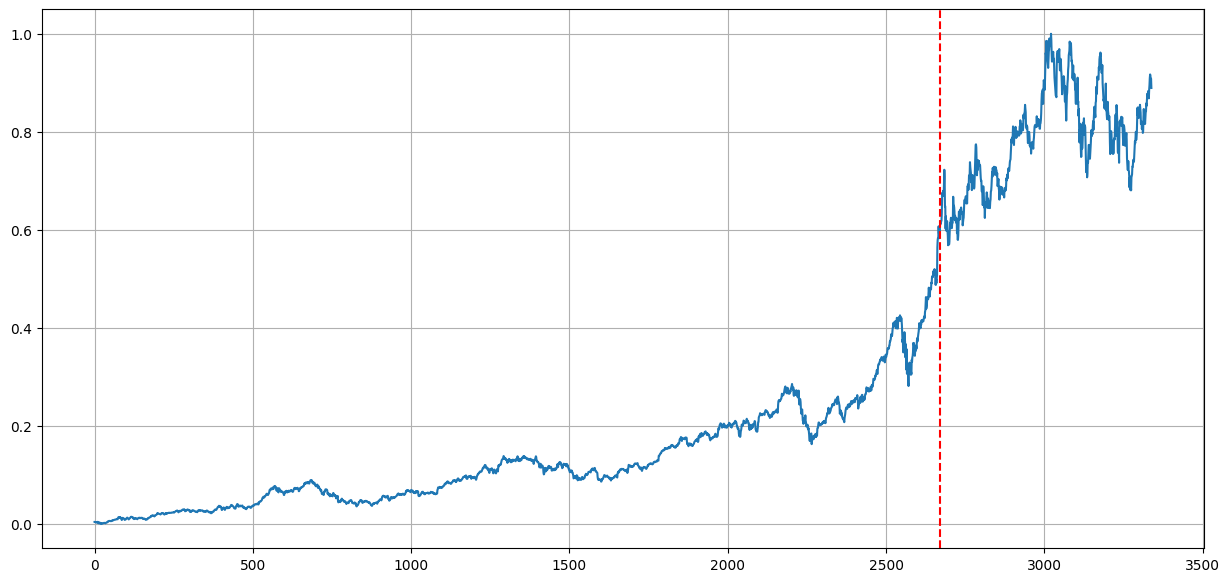

In [198]:
plt.figure(figsize=(15,7))
plt.plot(data.adj_close.tolist())
plt.axvline(len(train_data),color='red',linestyle='--')
plt.grid()
plt.show()

In [199]:
# data_loader.get_data()[0].head()

In [200]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

# 시계열 데이터셋 클래스 정의
class TimeSeriesDataset(Dataset):
    def __init__(self, data, group, sequence_size, window_size, future_size, infer_mode):
        assert len([x for x in data['group'] if x not in ['train','test']])==0, \
            "data['group'] must be in ['train','test']"
        assert group in ['train','test'], \
            "group must be in ['train','test']"
        
        self.infer_mode = infer_mode
        self.group = group
        
        # make sequence
        self.train_x_list, self.train_y_list = [],[]
        self.test_x_list , self.test_y_list  = [],[]
        i=0
        while True:
            if len(data)<i+sequence_size+future_size:
                break
            grp   = data.iloc[i+sequence_size:,:]['group'].values[0]
            seq_x = data.drop(['date','group'],axis=1).iloc[i:i+sequence_size,:].values
            seq_y = data.drop(['date','group'],axis=1).iloc[i+sequence_size:i+sequence_size+future_size,-1].values
            if grp=='train':
                self.train_x_list.append(torch.Tensor(seq_x))
                self.train_y_list.append(torch.Tensor(seq_y))
            elif grp=='test':
                self.test_x_list.append(torch.Tensor(seq_x))
                self.test_y_list.append(torch.Tensor(seq_y))
            else:
                raise ValueError("data['group'] must be in ['train','test']")
            i+=window_size
            
        # make train/test set
        self.x_list, self.y_list = None, None
        if self.group=='train':
            self.x_list = self.train_x_list.copy()
            self.y_list = self.train_y_list.copy()
        elif self.group=='test':
            self.x_list = self.test_x_list.copy()
            self.y_list = self.test_y_list.copy()
        else:
            raise ValueErorr("group must be in ['train','test']")
            
    def __getitem__(self, index):
            
        data  = self.x_list[index]
        label = self.y_list[index]
        if self.infer_mode == False:
            return data, label
        else:
            return data

    def __len__(self):
        return len(self.x_list)

In [201]:
# 데이터셋 생성
train_dataset = TimeSeriesDataset(data, 'train', SEQUENCE_SIZE, WINDOW_SIZE, FUTURE_SIZE, False)
test_dataset  = TimeSeriesDataset(data, 'test' , SEQUENCE_SIZE, WINDOW_SIZE, FUTURE_SIZE, False)

# 데이터 로더 생성
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
test_dataloader  = DataLoader(test_dataset , batch_size=BATCH_SIZE, shuffle=SHUFFLE)

In [202]:
# # 데이터셋 생성
# train_dataset = TimeSeriesDataset(train_data, SEQUENCE_SIZE, WINDOW_SIZE, FUTURE_SIZE, False)
# test_dataset  = TimeSeriesDataset(test_data , SEQUENCE_SIZE, WINDOW_SIZE, FUTURE_SIZE, False)

# # 데이터 로더 생성
# train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
# test_dataloader  = DataLoader(test_dataset , batch_size=BATCH_SIZE, shuffle=SHUFFLE)

In [203]:
[x for x,y in train_dataloader][0].size(), [y for x,y in train_dataloader][0].size()
# [x for x,y in test_dataloader][0].size(), [y for x,y in test_dataloader][0].size()

(torch.Size([32, 21, 8]), torch.Size([32, 1]))

In [204]:
print([x for x,y in train_dataloader][0][0], [y for x,y in train_dataloader][0][0])
display(train_data.head(SEQUENCE_SIZE+1).tail())

tensor([[1.4447e-03, 1.7472e-03, 2.9537e-03, 3.4005e-03, 2.9641e-03, 3.4057e-03,
         3.2475e-03, 3.8178e-03],
        [1.7472e-03, 2.9537e-03, 3.4005e-03, 2.9641e-03, 3.4057e-03, 3.2475e-03,
         3.8178e-03, 3.8821e-03],
        [2.9537e-03, 3.4005e-03, 2.9641e-03, 3.4057e-03, 3.2475e-03, 3.8178e-03,
         3.8821e-03, 3.2892e-03],
        [3.4005e-03, 2.9641e-03, 3.4057e-03, 3.2475e-03, 3.8178e-03, 3.8821e-03,
         3.2892e-03, 3.2214e-03],
        [2.9641e-03, 3.4057e-03, 3.2475e-03, 3.8178e-03, 3.8821e-03, 3.2892e-03,
         3.2214e-03, 3.4648e-03],
        [3.4057e-03, 3.2475e-03, 3.8178e-03, 3.8821e-03, 3.2892e-03, 3.2214e-03,
         3.4648e-03, 3.1397e-03],
        [3.2475e-03, 3.8178e-03, 3.8821e-03, 3.2892e-03, 3.2214e-03, 3.4648e-03,
         3.1397e-03, 2.7242e-03],
        [3.8178e-03, 3.8821e-03, 3.2892e-03, 3.2214e-03, 3.4648e-03, 3.1397e-03,
         2.7242e-03, 3.2336e-03],
        [3.8821e-03, 3.2892e-03, 3.2214e-03, 3.4648e-03, 3.1397e-03, 2.7242e-03,

,date,open,high,low,volume,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,adj_close_lag_4,adj_close_lag_5,adj_close_lag_6,adj_close_lag_7,close_change,volume_change,close_ma_5,close_sd_5,volume_ma_5,volume_sd_5,bollinger_band_upper_5,bollinger_band_lower_5,close_ma_10,close_sd_10,volume_ma_10,volume_sd_10,bollinger_band_upper_10,bollinger_band_lower_10,close_ma_20,close_sd_20,volume_ma_20,volume_sd_20,bollinger_band_upper_20,bollinger_band_lower_20,close_ma_60,close_sd_60,volume_ma_60,volume_sd_60,bollinger_band_upper_60,bollinger_band_lower_60,close_ma_120,close_sd_120,volume_ma_120,volume_sd_120,bollinger_band_upper_120,bollinger_band_lower_120,macd_short,macd_long,macd,macd_signal,macd_sign,mean_close_change_1week,mean_volume_change_1week,mean_close_change_3week,mean_volume_change_3week,mean_close_change_6week,mean_volume_change_6week,mean_close_change_13week,mean_volume_change_13week,mean_close_change_26week,mean_volume_change_26week,mean_close_change_52week,mean_volume_change_52week,adj_close
17,2010-01-28,7.318929,7.339286,7.096429,1173502400,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2010,6.318945,6.259976,6.172735,6.011024,6.324720,6.435975,6.536589,-4.132161,-31.874845,6.164103,0.130353,1.342130e+09,4.292784e+08,6.424810,5.903396,6.274353,0.161519,9.687924e+08,4.916976e+08,6.597391,5.951315,6.348279,0.140412,734376860.0,4.194231e+08,6.629104,6.067454,6.149295,0.220526,5.628631e+08,2.889655e+08,6.590348,5.708242,5.812082,0.457019,5.277296e+08,2.502733e+08,6.726121,4.898043,6.288397,6.321822,-0.033425,0.084886,0,-0.809286,20.286862,-0.351332,8.681306,0.058605,6.557733,-0.018295,5.529435,0.193525,5.055682,0.357635,3.617579,6.057836
18,2010-01-29,7.181429,7.221429,6.794643,1245952400,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,2010,6.057836,6.318945,6.259976,6.172735,6.011024,6.324720,6.435975,-3.627913,6.173826,6.129511,0.190298,1.414967e+09,3.563393e+08,6.510108,5.748914,6.221553,0.207861,1.050098e+09,4.593985e+08,6.637275,5.805831,6.318520,0.179178,776070260.0,4.270750e+08,6.676875,5.960165,6.150688,0.218242,5.723126e+08,3.018118e+08,6.587172,5.714204,5.818808,0.451332,5.348846e+08,2.583686e+08,6.721471,4.916144,6.248728,6.314608,-0.065880,0.057213,0,-0.542901,12.523478,-0.580869,9.998777,-0.014774,7.276720,-0.063095,5.392062,0.155041,5.232506,0.348525,3.805954,5.838063
19,2010-02-01,6.870357,7.000000,6.832143,749876400,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2010,5.838063,6.057836,6.318945,6.259976,6.172735,6.011024,6.324720,1.390204,-39.815004,6.078809,0.208778,1.351802e+09,4.495329e+08,6.496364,5.661253,6.187509,0.227844,1.065679e+09,4.446177e+08,6.643197,5.731821,6.294202,0.198682,795943540.0,4.154116e+08,6.691567,5.896838,6.153718,0.213621,5.761015e+08,3.026023e+08,6.580960,5.726476,5.826409,0.445184,5.386311e+08,2.581978e+08,6.716777,4.936041,6.208402,6.308026,-0.099625,0.027074,0,-0.802908,0.388584,-0.532511,7.756914,0.016802,6.477811,-0.002881,3.914860,0.165207,4.935101,0.373166,3.699706,5.919224
20,2010-02-02,6.996786,7.011429,6.906429,698342400,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2010,5.919224,5.838063,6.057836,6.318945,6.259976,6.172735,6.011024,0.580279,-6.872333,6.017528,0.186037,1.118048e+09,4.173077e+08,6.389601,5.645455,6.129207,0.201686,1.062513e+09,4.473782e+08,6.532578,5.725836,6.266617,0.205999,806174180.0,4.100621e+08,6.678615,5.854619,6.156276,0.210206,5.796150e+08,3.027803e+08,6.576687,5.735865,5.834776,0.437942,5.414895e+08,2.580502e+08,6.710660,4.958893,6.174028,6.300731,-0.126703,-0.004368,0,-0.969518,-16.025963,-0.435016,7.081028,0.090324,5.910154,0.044787,3.683389,0.170151,5.006071,0.352625,3.602467,5.953572
21,2010-02-03,6.970357,7.150000,6.943571,615328000,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2010,5.953572,5.919224,5.838063,6.057836,6.318945,6.259976,6.172735,1.720614,-11.887349,5.964941,0.093862,8.966003e+08,2.909767e+08,6.152665,5.777217,6.091210,0.170915,1.062830e

In [205]:
class BiLSTM(nn.Module):
    def __init__(self, bidirectional, batch_norm, input_size, hidden_size, num_layers, output_size, dropout, seq_len):
        super(BiLSTM, self).__init__()
        self.bidirectional = bidirectional
        self.batch_norm = batch_norm
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = 2 if self.bidirectional else 1
        
        self.layers = nn.ModuleList()
        self.layers.append(nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=self.bidirectional))
        for i in range(num_layers-1):
            self.layers.append(
                nn.LSTM(hidden_size*self.num_directions, hidden_size, batch_first=True, bidirectional=self.bidirectional)
            )
        
        self.fc = nn.Linear(hidden_size*self.num_directions, output_size)
        self.dropout = nn.Dropout(dropout)
        if self.batch_norm:
            self.bn1 = nn.BatchNorm1d(seq_len)     #LSTM Layer 뒤에 있을 때
            self.bn2 = nn.BatchNorm1d(output_size) #Fully Connected 뒤에 있을 때
        self.activation = nn.LeakyReLU(negative_slope=0.01) #nn.ELU()
        
        # 초기 가중치 설정
        self.init_weights()
        
    def init_weights(self):
        for layer in self.layers:
            for name, param in layer.named_parameters():
                if 'weight' in name:
                    init.xavier_normal_(param.data)
                elif 'bias' in name:
                    init.constant_(param.data, 0)
                
        init.xavier_normal_(self.fc.weight)
        init.constant_(self.fc.bias, 0)

    def forward(self, x):
        # 초기 hidden state와 cell state를 0으로 초기화
        h0 = torch.zeros(self.num_directions, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_directions, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out = x
        for i in range(self.num_layers):
            out, (hn, cn) = self.layers[i](out, (h0, c0))
            out = self.dropout(out)
            # if self.batch_norm:
            #     out = self.bn1(out)
            #out = self.activation(out)
        
        # Fully connected layer
        out = out[:, -1, :] # 마지막 타임스텝의 hidden state를 선택
        out = self.fc(out)
        if self.batch_norm:
            out = self.bn2(out)
        out = self.activation(out)
        
        return out

In [206]:
data.tail()

,date,group,adj_close_lag_7,adj_close_lag_6,adj_close_lag_5,adj_close_lag_4,adj_close_lag_3,adj_close_lag_2,adj_close_lag_1,adj_close
3334,2023-04-03,test,0.875583,0.883132,0.871865,0.868262,0.886106,0.895200,0.909727,0.916991
3335,2023-04-04,test,0.883132,0.871865,0.868262,0.886106,0.895200,0.909727,0.916991,0.913902
3336,2023-04-05,test,0.871865,0.868262,0.886106,0.895200,0.909727,0.916991,0.913902,0.903207
3337,2023-04-06,test,0.868262,0.886106,0.895200,0.909727,0.916991,0.913902,0.903207,0.908354
3338,2023-04-10,test,0.886106,0.895200,0.909727,0.916991,0.913902,0.903207,0.908354,0.889424


In [207]:
# 모델 인스턴스 생성 및 손실함수, 최적화 함수 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BiLSTM(
    bidirectional=BIDIRECTIONAL,
    batch_norm=BATCH_NORM,
    input_size=data.shape[1]-len(idx_features), #train_data.shape[1]-1
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    output_size=FUTURE_SIZE,
    dropout=DROPOUT,
    seq_len=SEQUENCE_SIZE,
)
model = model.to(device)
print(model)

BiLSTM(
  (layers): ModuleList(
    (0): LSTM(8, 64, batch_first=True)
    (1): LSTM(64, 64, batch_first=True)
  )
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (activation): LeakyReLU(negative_slope=0.01)
)


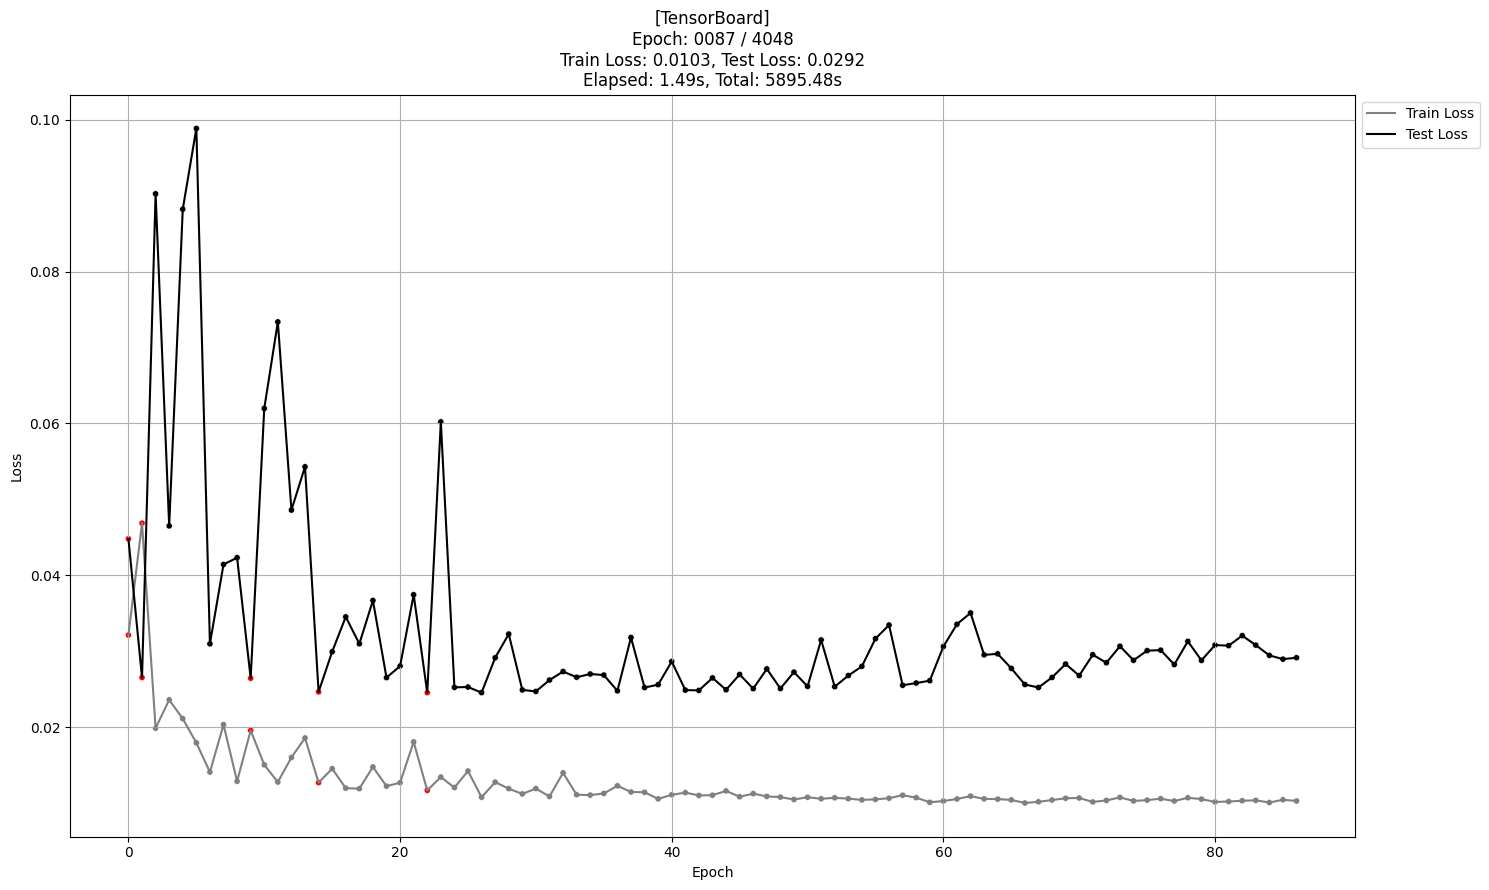

KeyboardInterrupt: 

In [208]:
%%time

seed_everything(SEED)

criterion = nn.L1Loss()  #nn.MSELoss(),nn.HuberLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=LEARNING_RATE,weight_decay=5e-4) # weight_decay: L2 regularization의 일종
# optimizer = torch.optim.SGD(params=model.parameters(),lr=lr,momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10, threshold_mode='abs',min_lr=1e-7, verbose=False)
early_stopping = EarlyStopping(patience=30, verbose=False, path=None) #'./mc/checkpoint.pt'

best_model = train(
    model,
    train_dataloader,
    test_dataloader,
    criterion,
    optimizer,
    scheduler,
    device,
    num_epochs=4048,
    metric_period=1,
    target_logscale=TARGET_LOGSCALE,
    early_stopping=None,#early_stopping,
    plot=True,
    s=20,
)

In [209]:
# 모델 인스턴스 생성 및 손실함수, 최적화 함수 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BiLSTM(
    bidirectional=BIDIRECTIONAL,
    batch_norm=BATCH_NORM,
    input_size=data.shape[1]-len(idx_features), #train_data.shape[1]-1
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    output_size=FUTURE_SIZE,
    dropout=DROPOUT,
    seq_len=SEQUENCE_SIZE,
)
model = model.to(device)
model.load_state_dict(torch.load('./mc/best_model.pt'))
# model.load_state_dict(torch.load('./mc/final_model.pt'))

<All keys matched successfully>

In [210]:
def predict(model, dataloader, device, target_logscale):
    with torch.no_grad():
        preds = []
        trues = []
        model.eval()
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)

            output = model(x)
            preds += output.detach().cpu().numpy().flatten().tolist()
            trues += y.detach().cpu().numpy().flatten().tolist()
            
    if target_logscale:
        preds = [np.exp(pred) for pred in preds]
        trues = [np.exp(true) for true in trues]
            
    return trues, preds

In [211]:
train_data.head()

,date,open,high,low,volume,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,adj_close_lag_4,adj_close_lag_5,adj_close_lag_6,adj_close_lag_7,close_change,volume_change,close_ma_5,close_sd_5,volume_ma_5,volume_sd_5,bollinger_band_upper_5,bollinger_band_lower_5,close_ma_10,close_sd_10,volume_ma_10,volume_sd_10,bollinger_band_upper_10,bollinger_band_lower_10,close_ma_20,close_sd_20,volume_ma_20,volume_sd_20,bollinger_band_upper_20,bollinger_band_lower_20,close_ma_60,close_sd_60,volume_ma_60,volume_sd_60,bollinger_band_upper_60,bollinger_band_lower_60,close_ma_120,close_sd_120,volume_ma_120,volume_sd_120,bollinger_band_upper_120,bollinger_band_lower_120,macd_short,macd_long,macd,macd_signal,macd_sign,mean_close_change_1week,mean_volume_change_1week,mean_close_change_3week,mean_volume_change_3week,mean_close_change_6week,mean_volume_change_6week,mean_close_change_13week,mean_volume_change_13week,mean_close_change_26week,mean_volume_change_26week,mean_close_change_52week,mean_volume_change_52week,adj_close
0,2010-01-04,7.622500,7.660714,7.585000,493729600,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2010,6.405577,6.433239,6.356029,6.432327,6.354208,6.143252,6.090359,1.556503,40.100587,6.426490,0.054059,469599200.0,1.104894e+08,6.534609,6.318372,6.268639,0.199398,476460320.0,1.148788e+08,6.667435,5.869842,6.081439,0.243985,512897280.0,1.432467e+08,6.569409,5.593468,6.032636,0.210985,5.121124e+08,1.971307e+08,6.454606,5.610666,5.597253,0.517851,4.871276e+08,1.733008e+08,6.632955,4.561551,6.203893,6.074390,0.129503,0.001227,1,0.476902,3.187010,0.582433,3.733066,0.141220,5.351744,0.235566,4.326117,0.328492,4.396876,0.356272,3.956538,6.505280
1,2010-01-05,7.664286,7.699643,7.616071,601904800,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2010,6.505280,6.405577,6.433239,6.356029,6.432327,6.354208,6.143252,0.172890,21.909807,6.443330,0.067720,461067040.0,9.402018e+07,6.578771,6.307890,6.326241,0.175889,475773760.0,1.140175e+08,6.678019,5.974463,6.113447,0.257294,501648280.0,1.249581e+08,6.628034,5.598859,6.045357,0.216785,5.148406e+08,1.972233e+08,6.478927,5.611787,5.614352,0.514002,4.880969e+08,1.736171e+08,6.642356,4.586348,6.252908,6.086303,0.166605,0.033720,1,0.265599,1.832118,0.653692,6.009165,0.235187,4.585978,0.275495,4.705599,0.327329,4.746185,0.375142,4.020269,6.516527
2,2010-01-06,7.656429,7.686786,7.526786,552160000,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2010,6.516527,6.505280,6.405577,6.433239,6.356029,6.432327,6.354208,-1.590633,-8.264563,6.454699,0.052450,482457920.0,1.013875e+08,6.559599,6.349799,6.364967,0.141643,469799120.0,1.074687e+08,6.648252,6.081682,6.146914,0.250076,493518340.0,1.152776e+08,6.647065,5.646762,6.055743,0.219244,5.191554e+08,1.951144e+08,6.494230,5.617255,5.630424,0.508490,4.894185e+08,1.734950e+08,6.647404,4.613444,6.301316,6.098439,0.202877,0.067731,1,0.184705,6.365077,0.468543,4.434160,0.191975,5.144308,0.216658,4.494606,0.312933,4.718122,0.366153,4.083964,6.412873
3,2010-01-07,7.562500,7.571429,7.466071,477131200,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2010,6.412873,6.516527,6.505280,6.405577,6.433239,6.356029,6.432327,-0.184863,-13.588235,6.448255,0.057484,495467280.0,9.400452e+07,6.563223,6.333287,6.396033,0.103710,482560680.0,9.882799e+07,6.603454,6.188612,6.178390,0.239740,482854960.0,1.055617e+08,6.657871,5.698909,6.065759,0.221085,5.223072e+08,1.928316e+08,6.507928,5.623589,5.645326,0.504604,4.883766e+08,1.731875e+08,6.654535,4.636118,6.339692,6.110913,0.228779,0.100330,1,-0.095217,5.135336,0.551320,4.554663,0.086439,4.132101,0.204495,4.647505,0.326645,4.694758,0.371408,4.251980,6.401018
4,2010-01-08,7.510714,7.571429,7.466429,447610800,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,2010,6.401018,6.412873,6.516527,6.505280,6.405577,6.433239,6.356029,0.664832,-6.187061,6.455854,0.052748,514507280.0,6.196748e+07,6.561350,6.350359,6.426065,0.053898,492769200.0,8.775185e+07,6.533862,6.318269,6.1

In [212]:
def inverse_transform(y,y_min,y_max):
    new_y = np.array(y)*(y_max-y_min)+y_min
    return new_y.tolist()

Train RMSE: 5.147603673865452
Test  RMSE: 5.349168039779787
(1) Train


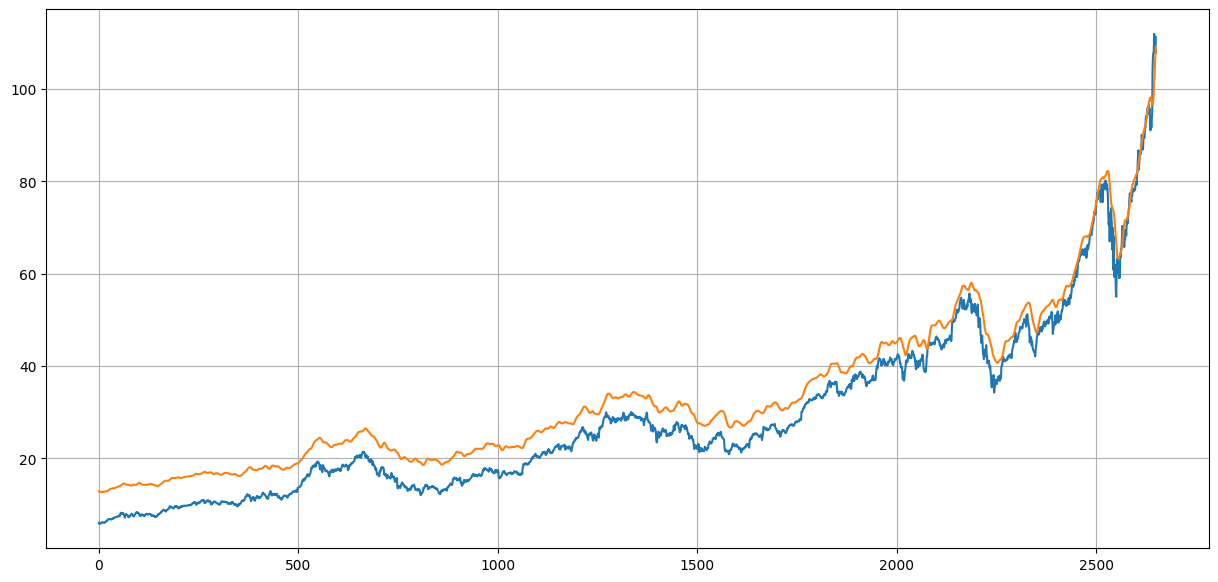

(2) Test


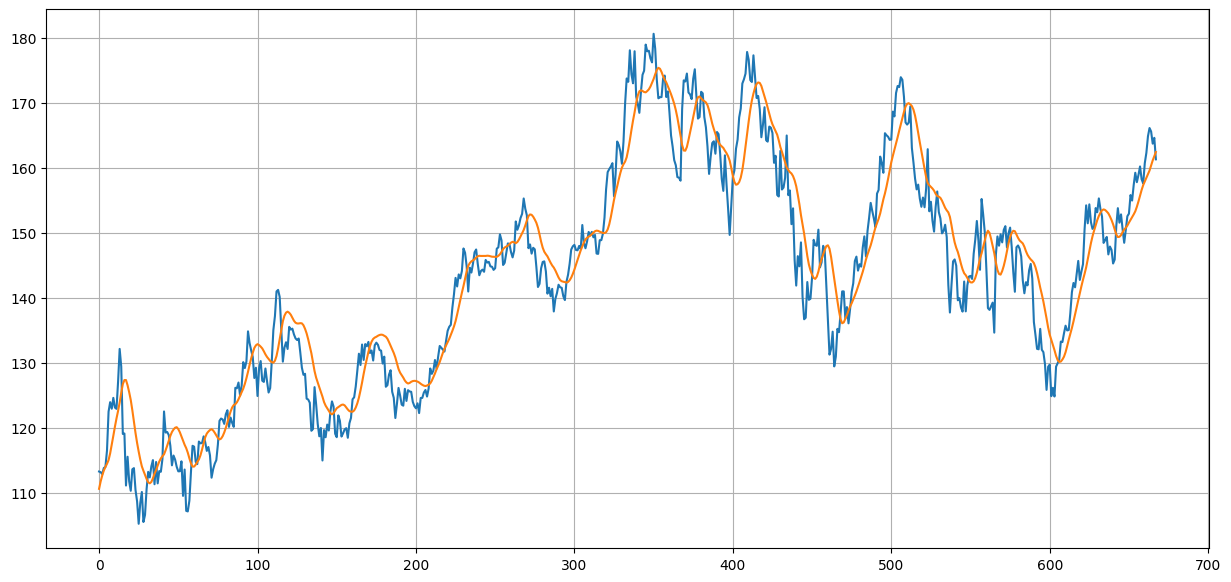

(3) Total


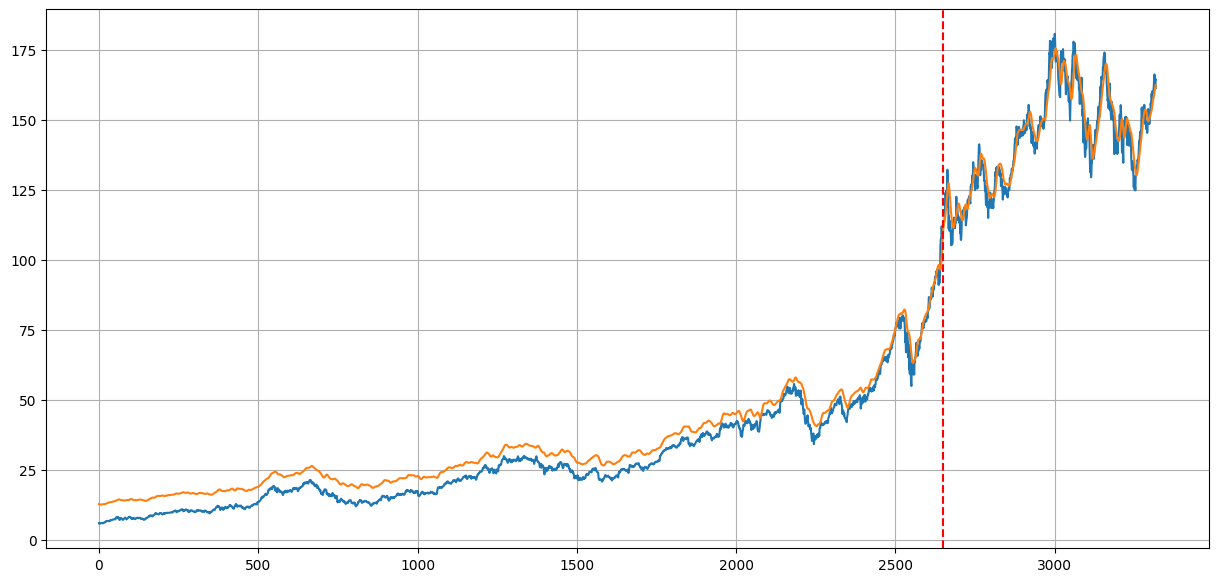

In [213]:
tr_trues, tr_preds = predict(model, train_dataloader, 'cpu', TARGET_LOGSCALE)
te_trues, te_preds = predict(model, test_dataloader , 'cpu', TARGET_LOGSCALE)

tr_trues = inverse_transform(tr_trues,y_min,y_max)
tr_preds = inverse_transform(tr_preds,y_min,y_max)
te_trues = inverse_transform(te_trues,y_min,y_max)
te_preds = inverse_transform(te_preds,y_min,y_max)

print(f'Train RMSE: {np.sqrt(mean_squared_error(tr_trues,tr_preds))}')
print(f'Test  RMSE: {np.sqrt(mean_squared_error(te_trues,te_preds))}')

print('(1) Train')
plt.figure(figsize=(15,7))
plt.plot(tr_trues)
plt.plot(tr_preds)
plt.grid()
plt.show()

print('(2) Test')
plt.figure(figsize=(15,7))
plt.plot(te_trues)
plt.plot(te_preds)
plt.grid()
plt.show()

print('(3) Total')
plt.figure(figsize=(15,7))
plt.plot(tr_trues+te_trues)
plt.plot(tr_preds+te_preds)
plt.axvline(len(tr_trues),color='red',linestyle='--')
plt.grid()
plt.show()

In [214]:
len(tr_trues), len(train_data)

(2650, 2671)

In [215]:
train_data.head()

,date,open,high,low,volume,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,adj_close_lag_4,adj_close_lag_5,adj_close_lag_6,adj_close_lag_7,close_change,volume_change,close_ma_5,close_sd_5,volume_ma_5,volume_sd_5,bollinger_band_upper_5,bollinger_band_lower_5,close_ma_10,close_sd_10,volume_ma_10,volume_sd_10,bollinger_band_upper_10,bollinger_band_lower_10,close_ma_20,close_sd_20,volume_ma_20,volume_sd_20,bollinger_band_upper_20,bollinger_band_lower_20,close_ma_60,close_sd_60,volume_ma_60,volume_sd_60,bollinger_band_upper_60,bollinger_band_lower_60,close_ma_120,close_sd_120,volume_ma_120,volume_sd_120,bollinger_band_upper_120,bollinger_band_lower_120,macd_short,macd_long,macd,macd_signal,macd_sign,mean_close_change_1week,mean_volume_change_1week,mean_close_change_3week,mean_volume_change_3week,mean_close_change_6week,mean_volume_change_6week,mean_close_change_13week,mean_volume_change_13week,mean_close_change_26week,mean_volume_change_26week,mean_close_change_52week,mean_volume_change_52week,adj_close
0,2010-01-04,7.622500,7.660714,7.585000,493729600,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2010,6.405577,6.433239,6.356029,6.432327,6.354208,6.143252,6.090359,1.556503,40.100587,6.426490,0.054059,469599200.0,1.104894e+08,6.534609,6.318372,6.268639,0.199398,476460320.0,1.148788e+08,6.667435,5.869842,6.081439,0.243985,512897280.0,1.432467e+08,6.569409,5.593468,6.032636,0.210985,5.121124e+08,1.971307e+08,6.454606,5.610666,5.597253,0.517851,4.871276e+08,1.733008e+08,6.632955,4.561551,6.203893,6.074390,0.129503,0.001227,1,0.476902,3.187010,0.582433,3.733066,0.141220,5.351744,0.235566,4.326117,0.328492,4.396876,0.356272,3.956538,6.505280
1,2010-01-05,7.664286,7.699643,7.616071,601904800,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2010,6.505280,6.405577,6.433239,6.356029,6.432327,6.354208,6.143252,0.172890,21.909807,6.443330,0.067720,461067040.0,9.402018e+07,6.578771,6.307890,6.326241,0.175889,475773760.0,1.140175e+08,6.678019,5.974463,6.113447,0.257294,501648280.0,1.249581e+08,6.628034,5.598859,6.045357,0.216785,5.148406e+08,1.972233e+08,6.478927,5.611787,5.614352,0.514002,4.880969e+08,1.736171e+08,6.642356,4.586348,6.252908,6.086303,0.166605,0.033720,1,0.265599,1.832118,0.653692,6.009165,0.235187,4.585978,0.275495,4.705599,0.327329,4.746185,0.375142,4.020269,6.516527
2,2010-01-06,7.656429,7.686786,7.526786,552160000,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2010,6.516527,6.505280,6.405577,6.433239,6.356029,6.432327,6.354208,-1.590633,-8.264563,6.454699,0.052450,482457920.0,1.013875e+08,6.559599,6.349799,6.364967,0.141643,469799120.0,1.074687e+08,6.648252,6.081682,6.146914,0.250076,493518340.0,1.152776e+08,6.647065,5.646762,6.055743,0.219244,5.191554e+08,1.951144e+08,6.494230,5.617255,5.630424,0.508490,4.894185e+08,1.734950e+08,6.647404,4.613444,6.301316,6.098439,0.202877,0.067731,1,0.184705,6.365077,0.468543,4.434160,0.191975,5.144308,0.216658,4.494606,0.312933,4.718122,0.366153,4.083964,6.412873
3,2010-01-07,7.562500,7.571429,7.466071,477131200,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2010,6.412873,6.516527,6.505280,6.405577,6.433239,6.356029,6.432327,-0.184863,-13.588235,6.448255,0.057484,495467280.0,9.400452e+07,6.563223,6.333287,6.396033,0.103710,482560680.0,9.882799e+07,6.603454,6.188612,6.178390,0.239740,482854960.0,1.055617e+08,6.657871,5.698909,6.065759,0.221085,5.223072e+08,1.928316e+08,6.507928,5.623589,5.645326,0.504604,4.883766e+08,1.731875e+08,6.654535,4.636118,6.339692,6.110913,0.228779,0.100330,1,-0.095217,5.135336,0.551320,4.554663,0.086439,4.132101,0.204495,4.647505,0.326645,4.694758,0.371408,4.251980,6.401018
4,2010-01-08,7.510714,7.571429,7.466429,447610800,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,2010,6.401018,6.412873,6.516527,6.505280,6.405577,6.433239,6.356029,0.664832,-6.187061,6.455854,0.052748,514507280.0,6.196748e+07,6.561350,6.350359,6.426065,0.053898,492769200.0,8.775185e+07,6.533862,6.318269,6.1

In [216]:
def predict_future(model, test_dataloader, n_future, sequence_size, target_logscale):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    last_21_days = [x for x,y in test_dataloader][-1][-1,:,:].unsqueeze(0)
    
    preds = []
    for i in range(n_future):
        with torch.no_grad():
            pred = model(last_21_days)
            preds.append(pred.item())
            
            new_data = torch.cat((last_21_days[:,-1,1:],pred),axis=1).unsqueeze(0)
            last_21_days = torch.cat((
                last_21_days[:,1:,:],
                new_data,
            ), axis=1)
            #    -3, -2, -1, -0
            # -> -2, -1, -0, pred
    
    if target_logscale:
        preds = np.exp(preds).tolist()
    
    return preds

In [221]:
n_future = 100
future_k = predict_future(model, test_dataloader, n_future, SEQUENCE_SIZE, TARGET_LOGSCALE)
future_k = inverse_transform(future_k,y_min,y_max)

(3) Total


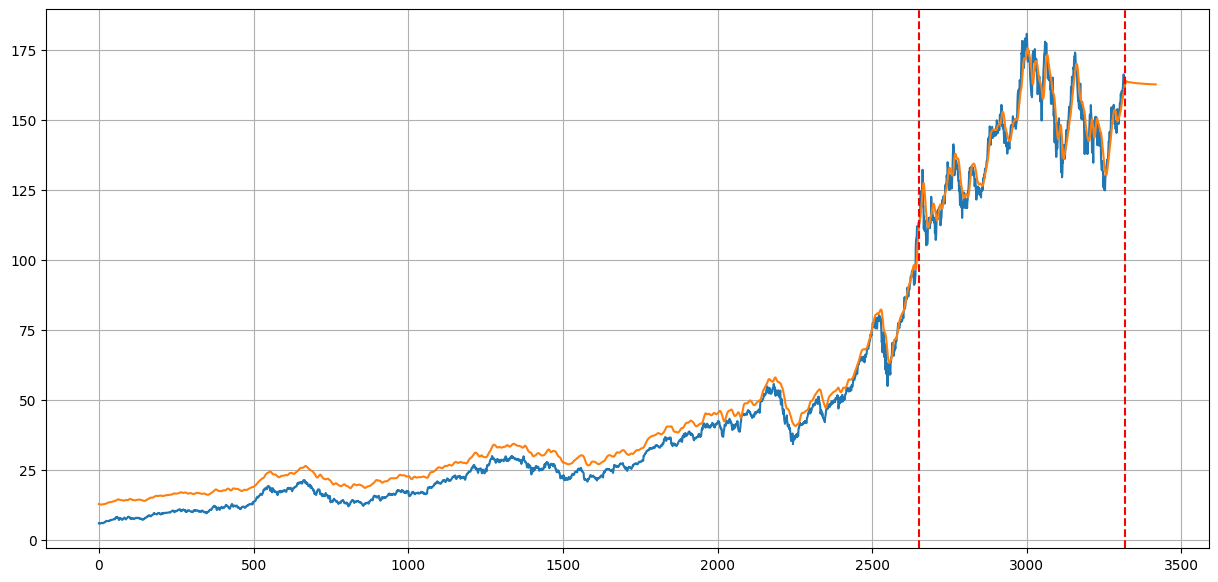

In [222]:
print('(3) Total')
plt.figure(figsize=(15,7))
plt.plot(tr_trues+te_trues+[np.nan]*n_future)
plt.plot(tr_preds+te_preds+future_k)
plt.axvline(len(tr_trues),color='red',linestyle='--')
plt.axvline(len(tr_trues+te_trues),color='red',linestyle='--')
plt.grid()
plt.show()

In [223]:
# !pip install prophet

In [ ]:
# conda install - c conda-forge fbprophet
import pandas as pd
from prophet import Prophet

# Load data
train_data, test_data = data_loader.get_data()
train_data = train_data[['date','adj_close']].rename(columns={'date':'ds','adj_close':'y'})
test_data  = test_data [['date','adj_close']].rename(columns={'date':'ds','adj_close':'y'})

# Initialize and fit model
m = Prophet(
    changepoint_prior_scale=0.2,
    n_changepoints=200,
    seasonality_mode=['multiplicative','additive'][0],
    weekly_seasonality=True,
    daily_seasonality=True,
    yearly_seasonality=True,
)
m.fit(train_data)

# Make future predictions
future = m.make_future_dataframe(periods=len(test_data))
forecast = m.predict(future)

# Plot forecast
fig = m.plot(forecast)

In [ ]:
test_data.head()

In [ ]:
tr_pred = forecast[:len(train_data)]['yhat'].values.tolist()
te_pred = forecast[len(train_data):]['yhat'].values.tolist()

tr_true = train_data['y'].values.tolist()
te_true = test_data ['y'].values.tolist()

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(tr_true+te_true,alpha=0.7)
plt.plot(tr_pred+te_pred,alpha=0.7)
plt.grid()
plt.axvline(len(tr_true),color='red',linestyle='--')
plt.show()

In [ ]:
# def predict_future(model, dataloader, device, target_logscale, n_predict):
#     with torch.no_grad():
#         preds = []
#         trues = []
#         model.eval()
#         for x, y in dataloader:
#             x = x.to(device)
#             y = y.to(device)

#             output = model(x)
#             preds += output.detach().cpu().numpy().flatten().tolist()
#             trues += y.detach().cpu().numpy().flatten().tolist()

#         # 예측한 주가를 n_predict만큼 미래로 확장
#         last_price = trues[-1]
#         for i in range(n_predict):
#             x_pred = torch.Tensor([last_price]).view(1, 1, 1).to(device)
#             print(x_pred)
#             output = model(x_pred)
#             pred = output.detach().cpu().numpy().flatten().tolist()[0]
#             if target_logscale:
#                 pred = np.exp(pred)
#             preds.append(pred)
#             last_price = pred

#         # 실제 주가와 예측한 주가 반환
#         if target_logscale:
#             trues = [np.exp(true) for true in trues]
#         return trues, preds

In [ ]:
predict_future(model, train_dataloader, 'cpu', TARGET_LOGSCALE, 30)

In [ ]:
def predict_future(model, data, n_predict):
    model.eval()
    with torch.no_grad():
        last_data = data[-4:].values.astype('float32')
        predicted_prices = []
        for i in range(n_predict):
            inputs = torch.tensor(last_data).unsqueeze(0)
            output = model(inputs)
            predicted_price = output.item()
            predicted_prices.append(predicted_price)
            last_data = np.concatenate([last_data[1:], [predicted_price]])            
    return predicted_prices

In [ ]:
train_data.shape

In [ ]:
for i in range(1,31):
    print(train_data.iloc[-31-30+i:-31+i,:].shape)

In [ ]:
x = train_data.iloc[-31-30+i:-31+i,:-1]
x = torch.Tensor(x.values)
x.shape

In [ ]:
x = train_data.iloc[-31-30+i:-31+i,:-1].values


In [ ]:
with torch.no_grad():
    
    predictions = []
    actuals = [] 
    model.eval()

    for i in range(1, 31):
        x = train_data.iloc[-31-30+i:-31+i,:-1].values
        y = train_data.iloc[-31-30+i:-31+i,-1].values[-1]
        
        x = x.reshape(x.shape[0],1,x.shape[1])
        x = torch.Tensor(x)
        output = model(x)
        predictions.append(output[-1].numpy()[0])
        actuals.append(y)

In [ ]:
plot_df = pd.DataFrame({
    'true':actuals,
    'pred':predictions,
})

# 예측 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(plot_df.true, label='Actual')
plt.plot(plot_df.pred, label='Predicted')
plt.legend()
plt.show()

<br></br>

In [ ]:
# seed_everything(SEED)

adj_close = pd.concat([train_data,test_data],axis=0)[['adj_close']]

# Create sequences
seq_len = 21
data = []
for i in range(len(adj_close)-seq_len):
    data.append(adj_close[i:i+seq_len])
data = np.array(data)

# Split data into train and test sets
train_size = 0.8
n_train = int(len(data)*train_size)
train_set, test_set = data[:n_train], data[n_train:]

# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, seq_len, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.activation = nn.ReLU()
        self.bn = nn.BatchNorm1d(seq_len)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        out = self.activation(out)
        return out
    
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate LSTM model and move to device
model = LSTM(seq_len=seq_len# Train model and save the best model
best_model = None
best_test_score = float('inf')
num_epochs = 100
for epoch in range(num_epochs):
    train_loss = []
    for seq in train_set:
        seq = torch.tensor(seq).float().unsqueeze(0).to(device)
        label = seq[:, -1, :].to(device)
        optimizer.zero_grad()
        output = model(seq)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss
    if (epoch+1) % 1 == 0:
        #print(output,label)
        with torch.no_grad():
            test_inputs = torch.from_numpy(test_set[:, :-1]).float().to(device)
            test_labels = torch.from_numpy(test_set[:, -1]).float().to(device)
            test_predictions = []
            for i in range(len(test_inputs)):
                seq = test_inputs[i].unsqueeze(0)
                with torch.no_grad():
                    test_predictions.append(model(seq).item())
            test_score = criterion(torch.tensor(test_predictions), test_labels).item()
            if test_score < best_test_score:
                torch.save(model.state_dict(), './mc/best_model.pth')
                best_test_score = test_score
                best_model = model
                is_best = 1
            else:
                is_best = 0
                
        progress_text = '{}Epoch [{}/{}], Train Loss: {:.4f}, Test Loss: {:.4f}'\
            .format(np.where(is_best==1,'*',' '),epoch+1, num_epochs, loss, test_score)
        print(progress_text)).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



In [ ]:
# Load the best model
best_model = LSTM(seq_len=seq_len).to(device)
best_model.load_state_dict(torch.load('./mc/best_model.pth'))

# Make train predictions
train_inputs = torch.from_numpy(train_set[:, :-1]).float().to(device)
train_labels = torch.from_numpy(train_set[:, -1]).float().to(device)
train_predictions = []
for i in range(len(train_inputs)):
    seq = train_inputs[i].unsqueeze(0)
    with torch.no_grad():
        train_predictions.append(best_model(seq).item())

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(train_labels.cpu().numpy(), train_predictions)

In [ ]:
# Load the best model
best_model = LSTM(seq_len=seq_len).to(device)
best_model.load_state_dict(torch.load('./mc/best_model.pth'))

# Make train predictions
test_inputs = torch.from_numpy(test_set[:, :-1]).float().to(device)
test_labels = torch.from_numpy(test_set[:, -1]).float().to(device)
test_predictions = []
for i in range(len(test_inputs)):
    seq = test_inputs[i].unsqueeze(0)
    with torch.no_grad():
        test_predictions.append(best_model(seq).item())

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test_labels.cpu().numpy(), test_predictions)

In [ ]:
true = adj_close['adj_close'].values.tolist()
true = true[7:]
pred = train_predictions + test_predictions

len(true),len(pred)

import matplotlib.pyplot as plt
plt.plot(true, label='Actual')
plt.plot(pred, label='Predicted')
plt.legend()
plt.axvline(len(train_predictions),color='red',linestyle='--')
plt.show()